In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as smp
import scienceplots
plt.style.use(['science','notebook'])

# 1. Introduction

The purpose of Monte Carlo simulation (MCS) is to simulate a real life experiment that depends on randomness to some extent. Below are some examples in the context of risk managment:

* An asset manager simulates potential oil price paths (mean-reverting Ornstein-Uhlenbeck process) to stress-test energy futures positions against commodity price crashes.

* A retail bank forecasts loan defaults by simulating monthly default counts (binomial distribution) and loss amounts (lognormal distribution) to estimate capital needs during economic downturns.

* An airline models IT system failures by simulating outage frequency (Poisson distribution) and repair times (exponential distribution) to optimize backup infrastructure budgets.

This file aims to introduce how to conduct MCS in Python. For most cases, the MCS process boils down into two steps: 

* Generating random variables according to a distribution; 

* Using those variables to conduct an experiment. 

I will go through these two steps in the next two sections, respectively. In the last section, I will use an example to demonstrate the whole simulation process. 

# 2. Generate Random Variables According to a Distribution
There are three common methods to generate random variables according to a certain distribution: built-in functions, analytical inverse of the distribution function, and search sort algorithm. We will illustrate all three methods below.

#### 2.1 Built-in functions

One example: generating 1000 samples from a Rayleigh distribution.

In [6]:
r = np.random.rayleigh(size=1000)

Below is the sample distribution histogram:

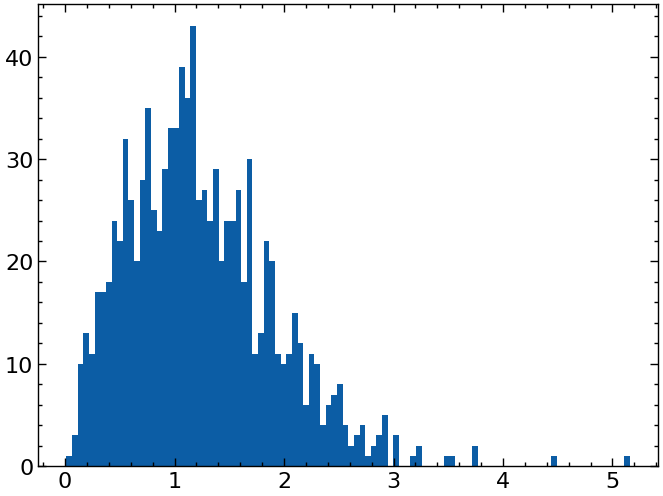

In [7]:
plt.hist(r, bins=100)
plt.show()

There are many other functions too. Check the description of numpy.random below:

In [ ]:
np.random?

#### 2.2 Simulating using a known inverse of the distribution function

Sometimes, there is not a built-in function for the distribution you want to generate from. If the cumulative distribution function (CDF) can be inverted analytically, you may use the method in this section to conduct the simulation. The principle of this method is given in the theorem below:

**Theorem:** If a random variable $X$ has a CDF of $F(x)$, then the variable $F^{-1}(U)$, where $U$ is a random uniform variable between 0 and 1, also has CDF $F(x)$. 

With this theorem, we can generate random numbers with CDF $F$ with the following steps:

* **Derive the inverse CDF**: Analytically solve $F(X)=y$ for $X$ to obtain $X=F^{-1}(y)$.

* **Generate uniform variables**: Use $U=RAND()$ in Excel to simulate $U \sim Uniform(0,1)$.

* **Apply the inverse CDF**: Substitute $U$ into $F^{-1}(U)$ to generate samples of $X$.

Below we use triangular distribution as an example. If random variable $X$ has a triangular distribution with best case $b$, worst case $w$, and most likely case $m$, we will have the CDF below:

$$ F(X)=\left\{
\begin{aligned}
\frac{(X-w)^{2}}{(m-w)(b-w)}, & \quad if\quad w \le X <m\\
1-\frac{(b-X)^{2}}{(b-m)(b-w)}, & \quad if \quad m \le X \le b
\end{aligned}
\right.
$$
Denote $y = F(X)$. We can get the inverse of $F$ analytically:
$$ X = F^{-1}(y)=\left\{
\begin{aligned}
w+\sqrt{(m-w)(b-w)y},& \quad if \quad 0 \le y < \frac{m-w}{b-w}\\
b-\sqrt{(b-m)(b-w)(1-y)}, & \quad if \quad \frac{(m-w)}{b-w} \le y \le 1
\end{aligned}
\right.
$$

Simulate $y$ that is uniformly distributed between 0 and 1, we can get the triangular distributed $F^{-1}(y)$. Below is how it’s done in Python.




In [13]:
# Define the inverse CDF F^{-1}
def F_inv(y, b, w, m):
    if y < (m-w) / (b-w):
        return w + np.sqrt((m-w)*(b-w)*y)
    else:
        return b - np.sqrt((b-w)*(b-m)*(1-y))

In [14]:
# Generate 10000 uniform random numbers Us
Us = np.random.rand(10000)

In [15]:
# Substitute Us into the inverse CDF to get the triangular distributed random numbers
# b = 50, w = 10, m = 35
F_inv_Us = np.array([F_inv(U, b=50, w=10, m=35) for U in Us])


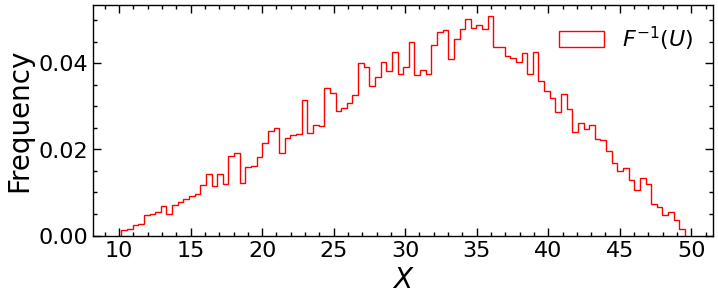

In [19]:
# Plot the histogram of the triangular distributed random numbers
plt.figure(figsize=(8,3))
plt.hist(F_inv_Us, histtype='step', color='red', density='norm', bins=100, label='$F^{-1}(U)$')
plt.legend()
plt.xlabel('$X$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend()
plt.show()

#### 2.3 Simulating using an empirical distribution

When historical data lacks a clear theoretical distribution (e.g., stock returns with irregular patterns or operational delays with unique trends), you can simulate values directly from observed data using the lookup method. This approach is ideal when:

* No parametric distribution adequately fits the data.

* You need to preserve the exact statistical properties of historical outcomes.

Then you can use the following steps:


* Assume we have N periods of historical data. Store the historical data in one array. 

In [40]:
# In this example, N = 50000, and the historical data is normally distributed.
his = np.random.normal(5, 1, 50000)

# Density function of historical data
x = np.linspace(0, 8, 5000)
f_his = 1/np.sqrt(2*np.pi) * np.exp(-0.5*(x-5)**2)

* Simulate n random integers from $1$ to $N$.

In [41]:
# In this example, N=5000.
Us = np.random.randint(low=0, high=50000, size=5000)


* Sampling from historical observations

In [42]:
sim_from_his = his[Us]

* Plot the histogram of the sampled historical observations

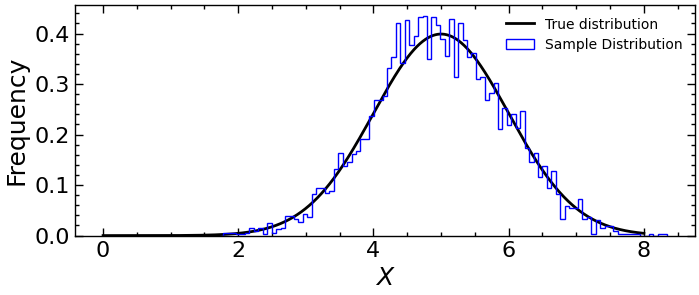

In [ ]:
# In this example, we plot the true distribution as well. 
plt.figure(figsize=(8,3))
plt.plot(x, f_his, color='black', label='True distribution')
plt.hist(sim_from_his, histtype='step', color='blue', density='norm', bins=100, label='Sample Distribution')
plt.legend(loc="upper right", prop={'size': 10})
plt.xlabel('$X$', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.show()

# 3. Example: Simulating Lunch Bills at a Restaurant

In this section, We will use the example below to demonstrate the MCS steps.

A restaurant would like to use a simulation model to analyze spending by customers. One lunch meal at this restaurant could have four components: drinks, main course, appetizer, and dessert. The owner has gathered the following data:

* Drinks spending is uniformly distributed between \$1.50 and \$6.00.

* A main course is ordered by 70 percent of customers. Among those who order a main course, their main course spending is normally distributed with a mean of \$15 and a standard deviation of \$3.

* An appetizer is ordered by 30 percent of customers whose drinking bills are greater than \$4.00, and 20 percent of customers whose drinking bills do not exceed \$4.00. Among those who order an appetizer, their appetizer spending is normally distributed with a mean of \$8 and a standard deviation of \$2.

* A dessert is ordered by 20 percent of customers. Each day, three desserts are offered, priced at \$3.50, \$4.00, and \$6.00. Customers are equally likely to order any one of these desserts.

We want to simulate 1000 trials of the lunch bills, and plot out the distribution. The steps are as follows:

